In [149]:
import numpy as np
from scipy.fftpack import dct
from skimage.io import imread, imshow
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt

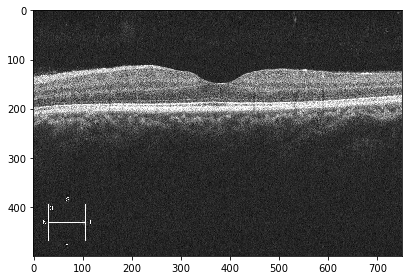

In [150]:
X = imread("NORMAL1.jpeg")
#Taking the first of the 3 channels, as they are all the same.
X = X[:,:,0]
h, w = X.shape
imshow(X)

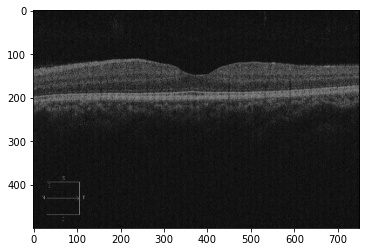

In [151]:
compression_factor = 2
mask = np.zeros((h,w))
mask[:,np.arange(0, w, compression_factor)] = 1
D = X*mask
plt.imshow(X*mask, cmap="gray")

In [152]:
# B1, S, B2t = np.linalg.svd(D, full_matrices=True)
print(B1.shape, B2t.shape)
B1 = dct(np.eye(h), norm='ortho', axis=0).T
B2t = dct(np.eye(w), norm='ortho', axis=0).T
print(B1.shape, B2t.shape)
W = B1.T @ D @ B2t
A = np.copy(W)
E = np.zeros_like(D)
Y1 = np.zeros_like(D)
Y2 = np.zeros_like(W)
nu1 = 3
nu2 = 3
mu = 0.5
lmda = 0.01
a = 0.85
ro = 1.0001
# plt.imshow(B1 @ W @ B2t, cmap="gray")


(500, 500) (750, 750)
(500, 500) (750, 750)


In [153]:
def SoftThresh(x, tau):
    # numpy automatically applies functions to each element of the array
    return np.sign(x)*np.maximum(0, np.abs(x) - tau)

def ShrinkageOperator(X, tau):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S = np.diag(SoftThresh(S,tau))
    return U @ S @ Vt

def Proj(X, mask):
    return X*(mask == 1).astype(int)

def AUpdate(W, Y1, mu):
    Z = W - (1/mu)*Y1
    return ShrinkageOperator(Z, 1/mu)

def WUpdate(mask, A, W, E, D, B1, B2t, Y1, Y2, mu, nu1, lmda):
    Z = B1 @ W @ B2t + E - D + (1/mu)*Y2
    Z = Proj(Z, mask)
    Z = B1.T @ Z @ B2t.T + W - A - (1/mu)*Y1
    Z = W - (1/nu1)*Z
    return SoftThresh(Z, lmda/(nu1*mu))

def EUpdate(mask, W, E, D, B1, B2t, Y2, mu, nu2, a):
    Z = E + B1 @ W @ B2t - D
    Z = Proj(Z, mask) + (1/mu)*Y2
    Z =  E - (1/nu2)*Z
    return SoftThresh(Z, a/(mu*nu2))

def Y1Update(mask, W, E, D, B1, B2t, Y1, mu):
    Z = B1 @ W @ B2t + E - D
    return Y1 + mu*Proj(Z, mask)

def Y2Update(A, W, Y2, mu):
    return Y2 + mu*(A - W)

def muUpdate(mu, ro):
    return mu*ro


In [154]:
iters = 2000
for i in range(iters):
    A = AUpdate(W, Y1, mu)
    W = WUpdate(mask, A, W, E, D, B1, B2t, Y1, Y2, mu, nu1, lmda)
    E = EUpdate(mask, W, E, D, B1, B2t, Y2, mu, nu2, a)
    Y1 = Y1Update(mask, W, E, D, B1, B2t, Y1, mu)
    Y2 = Y2Update(A, W, Y2, mu)
    mu = muUpdate(mu, ro)
    print(np.linalg.norm(B1 @ W @ B2t - X), np.linalg.norm(W, ord="nuc"))
    



35678.92661019134 150787.5519942321
35266.30692156423 153509.79832562798
35481.273729544744 154379.85546859395
36316.974000264294 154583.47690857138
38450.66200428837 160089.9011876725
43887.49301408584 183309.7746643043
57119.2729803422 250239.38672829187
86380.47675134658 404852.14828637714
145229.70274635416 716883.6611153154
257391.19783203886 1307553.3182587423
466799.75517133 2400755.5015422055
855624.4127158142 4414251.795821329
1577470.0569966792 8130964.081582513
2919599.741246199 15042713.367251813
5420021.120245228 28065900.620077446
10088211.293040616 52745550.89557811
18821890.183154006 99565088.89046083
35195215.671661735 188488745.87699744
65951642.14112341 357585699.42647564
123835371.76688324 679494481.1943549
232968567.72576153 1292896614.129292
439075231.343903 2462707164.4288917
828941005.4786255 4695223941.362706
1567488284.1354668 8958487998.794804
2968474203.6718225 17104111364.61861
5629410138.542059 32674985089.10476
10689223874.50708 62452250052.38769
20320642

KeyboardInterrupt: 

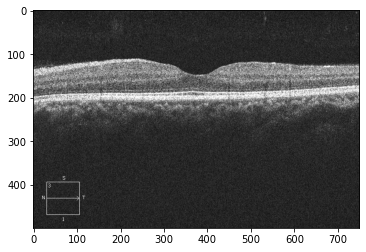

In [ ]:
plt.imshow(B1 @ W @ B2t, cmap="gray")

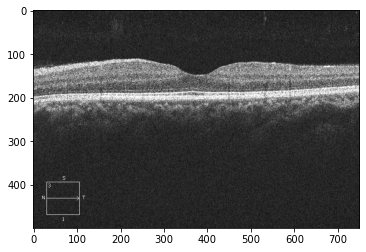

In [ ]:
plt.imshow(X, cmap="gray")

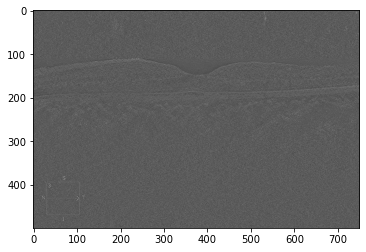

In [ ]:
plt.imshow(X - B1 @ W @ B2t, cmap="gray")